# DiSignAtlas

In [44]:
"""DiSignAtlas

This Notebook is used for exploring the DiSignAtlas dataset.

Strcuture:
    a. Disease Mapping
    b. Dataset Exploration
    c. DiSignAtlas get MeSH terms from Disease IDs
    
"""

'DiSignAtlas\n\nThis Notebook is used for exploring the DiSignAtlas dataset.\n\nStrcuture:\n    a. Disease Mapping\n'

## a. Disease Mapping

In [49]:
"""Disease Mapping
Here we are interested in Mapping the diseases to the corresponding MeSH terms.

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Disease Mapping
"""

# 1. Imports, Variables and Functions
# imports
import pandas as pd, numpy as np, os, sys, re, json, pickle, time, datetime, random
import requests
import xml.etree.ElementTree as ET
import logging
import json
from tqdm import tqdm
from bs4 import BeautifulSoup

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
data_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
mesh_file_path = "../data/MeSH/desc2023.xml"
output_path = os.path.join(
    "..", "results", "files", "DiSignAtlas", "disease_mapping.nlp.csv"
)
# functions


def retrieve_external_links(ids):
    base_url = "http://www.inbirg.com/disignatlas/detail/"
    results = {}

    for id in ids:
        url = f"{base_url}{id}"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            print(response.content)
            external_links_section = soup.find("div", {"id": "external_links"})
            print(external_links_section)
            if external_links_section:
                links = external_links_section.find_all("a")
                results[id] = [
                    link.get("href")
                    for link in links
                    if "MeSH" in link.text or "DO" in link.text
                ]
            else:
                results[id] = "No external links section found"
        else:
            results[id] = "Failed to retrieve data"

    return results


# 2. Load Data
# load disease info
# Example usage with a list of IDs
example_ids = ["DSA00047"]
retrieve_external_links(example_ids)

# load disease mapping


# 3. Disease Mapping
# map diseases to MeSH terms

# Discarded because it takes too long to run ! ! !
# disease_mapping = list()

# for disease in tqdm(diseases):
#     best_match, best_score = find_best_fuzzy_match(disease, disease_mesh_terms)
#     disease_mapping.append([disease, best_match, best_score])


# Load the 'en_core_web_md' model

# Perform disease mapping


# save disease mapping

b'<!DOCTYPE html>\n<html lang="en">\n\t<head>\n\t\t<meta charset="UTF-8">\n\t\t<title>Detail</title>\n\t\t<!-- Bootstrap CSS -->\n<link rel="stylesheet" href="/diseasedb_static/cdn/css/bootstrap-4.3.1.min.css">\n<script src="/diseasedb_static/cdn/js/jquery-3.2.1.min.js"></script>\n<!-- <script type="text/javascript" charset="utf8" src="http://code.jquery.com/jquery-1.10.2.min.js"></script> -->\n<!--jquery1_test-->\n<!-- <script type="text/javascript" charset="utf8" src="http://code.jquery.com/jquery-1.10.2.min.js"></script> -->\n<script src="/diseasedb_static/cdn/js/popper-1.15.0.min.js"></script>\n<script src="/diseasedb_static/cdn/js/bootstrap-4.3.1.min.js"></script>\n<!-- bootstrap-select -->\n<link rel="stylesheet" href="/diseasedb_static/cdn/css/bootstrap-select-1.13.14.min.css">\n<!-- <script src="https://cdn.jsdelivr.net/npm/bootstrap-select@1.13.14/dist/js/i18n/defaults-*.min.js"></script> -->\n<!-- cytoscape -->\n<!-- <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.co

{'DSA00047': 'No external links section found'}

In [46]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## b. Dataset Exploration


In [97]:
"""Dataset Exploration

The objective here is to retrieve information on the datasets. We are interested in answering the following questions:
    * How many datasets are there?
    * What types? 
    * What organisms?
    * How recent?
    * Is there overlap with iLINCS datasets?


Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Dataset Exploration

"""

# 1. Imports, Variables and Functions
# imports
import numpy as np, pandas as pd, os, sys, re, json, pickle, time, datetime, random
import logging
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
import re
import time
from Bio import Entrez
from multiprocessing import Pool
from http.client import IncompleteRead
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import random
import multiprocessing

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
filter_criteria = lambda s: (s["libraryid"] == "LIB_1")
base_url = "http://www.ilincs.org/api"

# functions


def get_date_from_geo(geo):
    """Get Date From GEO

    Function to retrieve date from GEO accesion code.

    Args:
        geo (str): GEO accession code.

    Returns:
        date (str): Date in fromat day month, year.
    """

    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo}"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        submission_date = None
        for tr in soup.find_all("tr", bgcolor="#eeeeee"):
            tds = tr.find_all("td")
            if tds and len(tds) >= 2 and "Submission date" in tds[0].get_text():
                submission_date = tds[1].get_text().strip()
                break
        return submission_date
    else:
        return None


def process_id(iLINCS_gds_id):
    Entrez.email = "your.email@example.com"
    attempts = 0
    max_attempts = 5
    sleep_time = 1  # seconds

    while attempts < max_attempts:
        try:
            # Search for the GDS database
            handle = Entrez.esearch(db="gds", term=iLINCS_gds_id)
            record = Entrez.read(handle)
            handle.close()

            if not record["IdList"]:
                return iLINCS_gds_id, "No ID found in record"

            record_id = record["IdList"][0]

            # Fetch the specific record in XML format
            handle = Entrez.efetch(db="gds", id=record_id, retmode="xml")
            data = handle.read()
            handle.close()

            match = re.search(r"Accession: GSE\d+", data)

            if match:
                accession_code = match.group(0).split("Accession: ")[1]
                return iLINCS_gds_id, accession_code
            else:
                return iLINCS_gds_id, "No accession code found."

        except IncompleteRead:
            attempts += 1
            time.sleep(sleep_time)
        except Exception as e:
            return iLINCS_gds_id, f"Error: {str(e)}"

    return iLINCS_gds_id, "Failed after multiple attempts"


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def process_dataset(dataset_id):
    # retrieve metadata from iLINCS for specific datasetid
    metadata = fetch_dataset_metadata(dataset_id)
    gds_id = metadata["SourceID"]
    return gds_id


# 2. Load Data
df_data_info = pd.read_csv(data_info_path)


# 3. Dataset Exploration

2024-01-11 16:01:21,269 - INFO - Nº of signatures: 10306
Nº of datasets: 5059


### * How many datasets are there?


In [234]:
logging.info(
    f"Nº of signatures: {df_data_info.shape[0]}\nNº of datasets: {df_data_info['accession'].nunique()}"
)

2024-01-12 15:17:58,410 - INFO - Nº of signatures: 10306
Nº of datasets: 5059


In [328]:
# check if we have these datasets in our files
not_found_datasets = list()
for dsaid in df_data_info["dsaid"].unique():
    # check microarray data path
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )
    if not os.path.exists(data_path):
        # check single cell data path
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )
        if not os.path.exists(data_path):
            not_found_datasets.append(dsaid)

logging.info(
    f"Nº of datasets not found: {len(not_found_datasets)}/{len(df_data_info['dsaid'].unique())}"
)

2024-01-13 15:15:34,534 - INFO - Nº of datasets not found: 0/10306


### * What types?


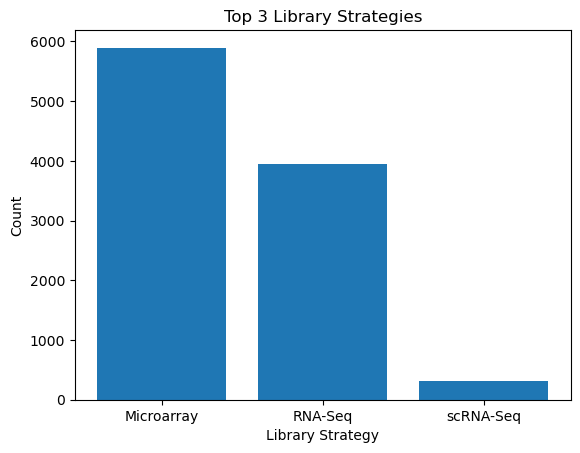

In [235]:
data = dict(df_data_info["library_strategy"].value_counts()[:3])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Creating the bar plot
plt.bar(labels, values)

# Adding titles and labels
plt.xlabel("Library Strategy")
plt.ylabel("Count")
plt.title("Top 3 Library Strategies")

# Show the plot
plt.show()

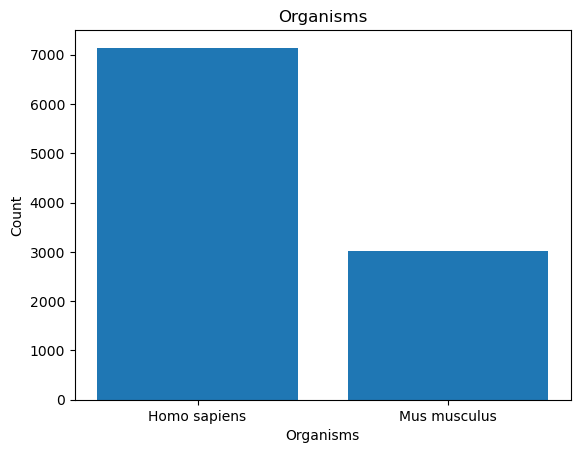

In [240]:
data = dict(df_data_info["organism"].value_counts()[:2])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Creating the bar plot
plt.bar(labels, values)

# Adding titles and labels
plt.xlabel("Organisms")
plt.ylabel("Count")
plt.title("Organisms")

# Show the plot
plt.show()

### * How recent?

In [127]:
# choose 100 random elements from the list
accessions = df_data_info["accession"].to_list()

subsample_accessions = random.sample(accessions, 100)


years = list()
for accession in tqdm(subsample_accessions):
    try:
        date = get_date_from_geo(accession)
        years.append(int(date.split(", ")[1]))
    except:
        logging.info(f"Failed to retrieve date for {accession}")
        pass

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


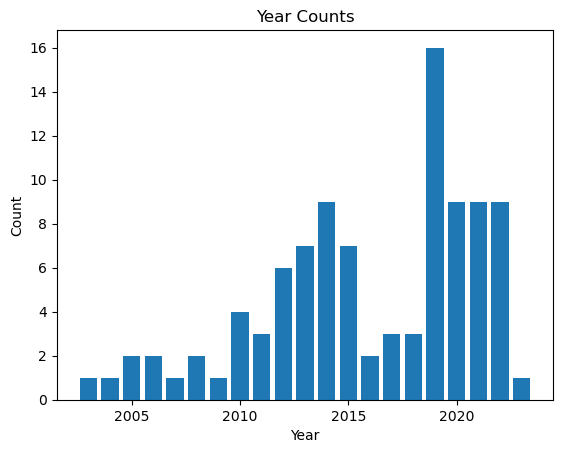

In [236]:
from collections import Counter

# Count the occurrences of each year
year_counts = Counter(years)

# Sort the years and get corresponding counts
sorted_years = sorted(year_counts.keys())
sorted_counts = [year_counts[year] for year in sorted_years]

# Create the bar plot
plt.bar(sorted_years, sorted_counts)

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Year Counts")

# Show the plot
plt.show()

### * Which is the overlap with iLINCS datasets?

In [146]:
# Assuming fetch_disease_signatures and fetch_dataset_metadata are predefined functions
signatures = fetch_disease_signatures()
datasets = list(set([s["datasetid"] for s in signatures if filter_criteria(s)]))


# Creating a pool of worker processes
pool = multiprocessing.Pool(multiprocessing.cpu_count())

# Map process_dataset over all datasets
results = list(tqdm(pool.imap(process_dataset, datasets), total=len(datasets)))

# Closing the pool and waiting for all processes to complete
pool.close()
pool.join()

# Assigning results to iLINCS_gds_ids
iLINCS_gds_ids = results

100%|██████████| 1087/1087 [00:24<00:00, 43.51it/s]


In [225]:
logging.info(
    f"Retrieved a total of {len(iLINCS_gds_ids)} iLINCS GDS IDs {len(set(iLINCS_gds_ids))} unique"
)

2024-01-12 15:04:56,596 - INFO - Retrieved a total of 1087 iLINCS GDS IDs 1084 unique


In [220]:
# Process the iLINCS GDS IDs -> GSE IDs
results = list()
for iLINCS_gds_id in tqdm(iLINCS_gds_ids):
    results.append(process_id(iLINCS_gds_id))
# Convert results to dictionary
gds_2_gse = dict(results)

100%|██████████| 1087/1087 [24:15<00:00,  1.34s/it]

{'GDS3417': 'GSE11971', 'GDS3483': 'GSE11341', 'GDS2791': 'GSE7146', 'GDS2255': 'GSE2322', 'GDS2219': 'GSE4296', 'GDS2834': 'Error: HTTP Error 400: Bad Request', 'GDS3759': 'GSE17009', 'GDS738': 'GSE1648', 'GDS2242': 'GSE2550', 'GDS1258': 'GSE1849', 'GDS2655': 'GSE6236', 'GDS4100': 'GSE14245', 'GDS1036': 'GSE1432', 'GDS2240': 'GSE2077', 'GDS961': 'GSE1009', 'GDS2055': 'GSE4667', 'GDS2310': 'GSE3606', 'GDS4146': 'GSE24427', 'GDS3471': 'GSE13280', 'GDS2959': 'GSE7400', 'GDS1023': 'GSE1801', 'GDS2682': 'GSE5543', 'GDS3042': 'GSE1922', 'GDS4291': 'GSE29959', 'GDS3128': 'GSE8397', 'GDS2881': 'GSE6344', 'GDS3342': 'GSE10896', 'GDS1442': 'GSE2853', 'GDS988': 'GSE1880', 'GDS2084': 'GSE5090', 'GDS2499': 'GSE6400', 'GDS3034': 'GSE7355', 'GDS3073': 'GSE8668', 'GDS2341': 'GSE5542', 'GDS4471': 'GSE37418', 'GDS3864': 'GSE22779', 'GDS806': 'GSE1379', 'GDS3126': 'GSE9714', 'GDS3499': 'GSE9988', 'GDS1028': 'GSE1739', 'GDS1210': 'GSE2685', 'GDS3041': 'GSE8527', 'GDS2429': 'GSE5099', 'GDS3631': 'GSE7894'

In [226]:
logging.info(
    f"Retrieved a total of {len([k for k, v in gds_2_gse.items() if v.startswith('GSE')])}/{len(gds_2_gse)} GDS to GSE mappings"
)

2024-01-12 15:05:58,223 - INFO - Retrieved a total of 1059/1084 GDS to GSE mappings


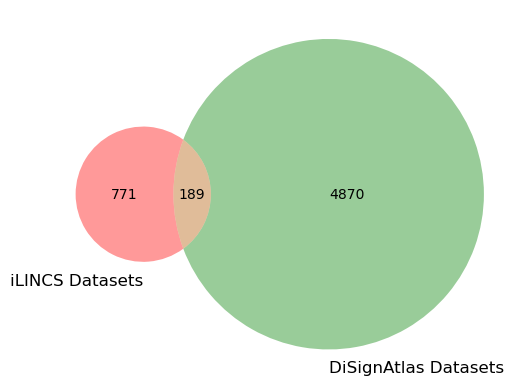

In [233]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Define the two lists
list1 = [v for k, v in gds_2_gse.items() if v.startswith("GSE")]
list2 = accessions

# Create the Venn diagram
venn2([set(list1), set(list2)], set_labels=("iLINCS Datasets", "DiSignAtlas Datasets"))

# Display the plot
plt.show()

## c. DiSignAtlas get MeSH terms from Disease IDs

In [41]:
"""DiSginAtlas DataSets

The objective here is to retrieve the datasets from DiSignAtlas.

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Retrieve DataSets
"""

# 1. Imports, Variables and Functions
# imports
import pandas as pd, numpy as np, os, sys, re, json, pickle, time, datetime, random
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json
import logging
from multiprocessing import Pool


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
dataset_info_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
Entrez.email = "dylandaltonsub@gmail.com"
data_path = "../data/DiseaseOntology/doid.obo"  # Replace with your file path
mesh_file_path = os.path.join("..", "data", "MeSH", "desc2023.xml")


# functions
def query_disignatlas(disease_id):
    """Query DiSignAtlas for a given disease id
    Args:
        disease_id (str): The disease id to query
    Returns:
        response.text: The response text
    """
    url = f"http://www.inbirg.com/disignatlas/detail/{disease_id}"
    response = requests.get(url)

    if response.status_code != 200:
        print("Unable to retrieve data")

    return response.text


def extract_mesh_terms(js_function_str):
    """Extract the MeSH terms from the JavaScript function string
    Args:
        js_function_str (str): The JavaScript function string
    Returns:
        mesh_terms (list): The MeSH terms
    """
    # Find the start of the dbXrefs string
    start = js_function_str.find('dbXrefs = "') + len('dbXrefs = "')
    # Find the end of the dbXrefs string
    end = js_function_str.find('"', start)
    # Extract the dbXrefs string
    dbXrefs_str = js_function_str[start:end]
    # Split the string by the pipe character
    dbXrefs = dbXrefs_str.split("|")
    # Filter out and return only the MeSH terms
    mesh_terms = [x for x in dbXrefs if x.startswith("MeSH:")]
    return mesh_terms


def extract_do_terms(js_function_str):
    """Extract the Disease Ontology terms from the JavaScript function string
    Args:
        js_function_str (str): The JavaScript function string
    Returns:
        do_terms (list): The DO terms
    """
    # Find the start of the dbXrefs string
    start = js_function_str.find('dbXrefs = "') + len('dbXrefs = "')
    # Find the end of the dbXrefs string
    end = js_function_str.find('"', start)
    # Extract the dbXrefs string
    dbXrefs_str = js_function_str[start:end]
    # Split the string by the pipe character
    dbXrefs = dbXrefs_str.split("|")
    # Filter out and return only the MeSH terms
    do_terms = [x for x in dbXrefs if x.startswith("DO:")]
    return do_terms


def process_disease_id_mesh(disease_id):
    # Retrieve data
    data = query_disignatlas(disease_id)
    # Extract mesh terms
    mesh_terms = extract_mesh_terms(data)
    # Return a tuple of disease_id and mesh_terms
    return disease_id, mesh_terms


def process_disease_id_do(disease_id):
    # Retrieve data
    data = query_disignatlas(disease_id)
    # Extract mesh terms
    do_terms = extract_do_terms(data)
    # Return a tuple of disease_id and mesh_terms
    return disease_id, do_terms


def parse_obo_file(file_path):
    with open(file_path, "r") as file:
        content = file.read()

    # Splitting the content into entries for each term
    terms = content.split("\n[Term]")
    mesh_terms = {}

    for term in terms:
        lines = term.split("\n")
        do_id = None
        mesh_id = None
        for line in lines:
            if line.startswith("id:"):
                do_id = line.split(": ")[1]
            if "xref: MESH:" in line:
                mesh_id = line.split("MESH:")[1].strip()
                if do_id and mesh_id:
                    if do_id in mesh_terms:
                        mesh_terms[do_id].append(mesh_id)
                    else:
                        mesh_terms[do_id] = [mesh_id]

    return mesh_terms


def find_mesh_tree_terms(mesh_ids, file_path):
    # Load and parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Create a dictionary to store tree terms for each MeSH ID
    mesh_tree_terms_dict = {mesh_id: None for mesh_id in mesh_ids}

    # Iterate through the XML to find each MeSH ID
    for descriptor in root.findall(".//DescriptorRecord"):
        descriptor_id = descriptor.find("./DescriptorUI")
        if descriptor_id is not None and descriptor_id.text in mesh_ids:
            # Extract tree terms
            tree_numbers = [tn.text for tn in descriptor.findall(".//TreeNumber")]
            mesh_tree_terms_dict[descriptor_id.text] = tree_numbers

    return mesh_tree_terms_dict


# 2. Load Data
# retrieve disease ids
df_dataset_info = pd.read_csv(dataset_info_path)

# disease concept ids
disease_ids = df_dataset_info["dsaid"].unique().tolist()

# 3. Retrieve MeSH Terms
# Stratergy 1: Retrieve MeSH terms directly
# retrieve MeSH id
# Create a pool of workers equal to the number of available CPU cores
with Pool() as pool:
    # Map the process_disease_id function to each disease_id
    # Use tqdm to show progress
    results = list(
        tqdm(pool.imap(process_disease_id_mesh, disease_ids), total=len(disease_ids))
    )

# Convert results to dictionary
disease_id_2_mesh_id = dict(results)

# Strategy 2: Retrieve MeSH terms from DO terms
# retrieve do terms
with Pool() as pool:
    # Map the process_disease_id function to each disease_id
    # Use tqdm to show progress
    results = list(
        tqdm(pool.imap(process_disease_id_do, disease_ids), total=len(disease_ids))
    )
# Convert the results to dictionary
disease_id_2_do_id = dict(results)

 26%|██▌       | 2703/10306 [04:23<11:03, 11.45it/s]

Unable to retrieve data


100%|██████████| 10306/10306 [22:17<00:00,  7.70it/s]


In [291]:
logging.info(
    f"Nº of successful mappings: {len([v for v in disease_id_2_mesh_id.values() if len(v)>0])} / {len(disease_id_2_mesh_id)}"
)

2024-01-13 14:06:10,752 - INFO - Nº of successful mappings: 8155 / 10306


In [299]:
# List of MeSH IDs you want to search for
mesh_ids = [
    e.split("MeSH:")[1] for sublist in disease_id_2_mesh_id.values() for e in sublist
]

mesh_id_2_mesh_symbols = find_mesh_tree_terms(mesh_ids, mesh_file_path)
# for id, terms in mesh_id_2_mesh_symbols.items():
#     print(f"MeSH ID: {id}, Tree Terms: {terms}")

In [308]:
# map mesh ids to mesh symbols
disease_id_2_mesh_symbol = dict()
for disease_id, mesh_ids in disease_id_2_mesh_id.items():
    mesh_symbols = list()
    for mesh_id in mesh_ids:
        key = mesh_id.split("MeSH:")[1]
        mesh_symbol = mesh_id_2_mesh_symbols.get(key)
        if mesh_symbol is not None:
            mesh_symbols.extend(mesh_symbol)
    disease_id_2_mesh_symbol[disease_id] = mesh_symbols

In [310]:
logging.info(
    f"Nº of successful mappings to MeSH symbols from MeSH ids: %d/%d"
    % (
        len([v for v in disease_id_2_mesh_symbol.values() if len(v) > 0]),
        len([v for v in disease_id_2_mesh_id.values() if len(v) > 0]),
    )
)

2024-01-13 14:53:46,466 - INFO - Nº of successful mappings to MeSH symbols from MeSH ids: 7790/8155


In [ ]:
logging.info(
    f"Nº of successful mappings: {len([v for v in disease_id_2_mesh_id.values() if len(v)>0])} / {len(disease_id_2_mesh_id)}"
)

In [ ]:
# Load and parse the XML file
tree = ET.parse(mesh_file_path)
root = tree.getroot()


# Create a dictionary to store tree terms for each MeSH ID
mesh_tree_terms_dict = {mesh_id: None for mesh_id in mesh_ids}

# Iterate through the XML to find each MeSH ID
for descriptor in root.findall(".//DescriptorRecord"):
    descriptor_id = descriptor.find("./DescriptorUI")
    if descriptor_id is not None and descriptor_id.text in mesh_ids:
        # Extract tree terms
        tree_numbers = [tn.text for tn in descriptor.findall(".//TreeNumber")]
        mesh_tree_terms_dict[descriptor_id.text] = tree_numbers

In [ ]:
# convert mesh ids to mesh terms

In [261]:
results = list()
do_to_mesh_terms = parse_obo_file(data_path)

for k, v in tqdm(disease_id_2_do_id.items()):
    mesh_ids = list()
    for do_id in v:
        try:
            mesh_ids.append(do_to_mesh_terms[do_id])
        except:
            pass
    results.append([k, mesh_ids])

disease_id_2_do_id_2 = dict(results)

100%|██████████| 10306/10306 [00:00<00:00, 1215388.21it/s]


## b. Compute Similarity Metrics

In [393]:
"""Compute Similarity Metrics

iLINCS bechmarked several methods for "connecting" transcriptional signatures.
These include Extreme & Weighted correlations, Connectivity Score, Connectivity Map
and correlation based on Log Significance. 

Overall, all six methods performed very well in the bechmark. The decision was made
to use the Extreme Correlation of Signed Log P-values utilizing top 100 up- and down-
regulated genes as it showd best performance. 

Weighted Correlations are also used as they are almost as good but esasier to compute.

Here we implement iLINCS Extreme Correlations.

Structure:
    1. Imports, Variables, Functions
    2. Retrieve Data & Compute Extreme Signed Significance
    3. Compute Correlation of Extreme Signed Significance
    4. Benchmark Results
"""


# 1. Imports, Variables, Functions
# imports
import scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd
import logging
import time, requests
import multiprocessing
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map  # For easy tqdm integration with Pool

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables


# functions


def compute_signed_significance(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    df = pd.read_csv(data_path, sep="\t")

    signed_significance = list()
    de_values = list()
    for index, row in df.iterrows():
        # Handle cases where AdjPValue is 0
        # or nan values
        if (row["AdjPValue"] != 0) and (not np.isnan(row["AdjPValue"])):
            sign = np.sign(row["Log2FC"])
            ss = sign * (-np.log10(row["AdjPValue"]))
            signed_significance.append((row["GeneID"], ss))
            de_values.append((row["GeneID"], row["Log2FC"]))

    return signed_significance, de_values


def compute_extreme_signed_significance(signed_significance, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance: list of tupples
        List of tupples [(geneid,ss), ...]
    - k: int()
        Top/Bottom k genes.

    Returns:
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # sort signed significance by value
    sorted_signed_significance = sorted(
        signed_significance, key=lambda x: x[1], reverse=True
    )

    # get top_bottom values
    top_bottom_genes = [ss[0] for ss in sorted_signed_significance[:k]] + [
        ss[0] for ss in sorted_signed_significance[-k:]
    ]

    # set values for non top/bottom k to 0
    extreme_signed_significance = {
        gene: ss if gene in top_bottom_genes else 0 for gene, ss in signed_significance
    }

    return extreme_signed_significance


def check_microarray_file_path(dsaid):
    """Check Microarray File Path
    Arguments:
        - dsaid: str
    Returns:
        - bool
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )
    return os.path.exists(data_path)


def check_number_of_significant_genes(extreme_signed_significance):
    """Check Number of Significant Genes

    Arguments:
        - extreme_signed_significance (dict): gene_id -> extreme signed significance
    Returns:
        - bool
    """
    values = np.array(list(extreme_signed_significance.values()), dtype=bool)
    if np.sum(values) == 200:
        return True
    else:
        return False


def process_dsaid(dsaid):
    if check_microarray_file_path(dsaid):
        signed_significance, de_values = compute_signed_significance(dsaid)
        extreme_signed_significance = compute_extreme_signed_significance(
            signed_significance
        )

        if check_number_of_significant_genes(extreme_signed_significance):
            return dsaid, extreme_signed_significance

        return dsaid, "Error: Nº of significant genes < 200"
    return dsaid, None


def get_all_significant_genes(disease_id_2_ess):
    """Get All Significant Genes

    Function to retrieve all significant genes from DiSignAtlas.

    Arguments:
        disease_id_2_ess (dict): Dictionary of disease ids to extreme signed significance.

    Returns:
        all_significant_genes (list): List of all significant genes.
    """
    all_significant_genes = set()
    for dsaid, ess in tqdm(disease_id_2_ess.items()):
        significant_genes = [k for k, v in ess.items() if v != 0]
        # update set
        all_significant_genes.update(significant_genes)

    # sort genes
    all_significant_genes = list(all_significant_genes)
    all_significant_genes.sort()

    return all_significant_genes


# 2. Retrieve Data & Compute Extreme Signed Significance
# retrieve signatures
# disease_id_2_ess = dict()
# for dsaid in tqdm(df_dataset_info["dsaid"].unique()):
#     if check_microarray_file_path(dsaid):
#         signed_significance, de_values = compute_signed_significance(dsaid)
#         extreme_signed_significance = compute_extreme_signed_significance(
#             signed_significance
#         )
#         disease_id_2_ess[dsaid] = extreme_signed_significance

# Using process_map for automatic tqdm integration
results = process_map(
    process_dsaid,
    df_dataset_info["dsaid"].unique(),
    max_workers=multiprocessing.cpu_count(),
)

disease_id_2_ess = {
    dsaid: ess
    for dsaid, ess in results
    if (ess is not None) and (not ess.startswith("Error"))
}


failed_dsaid_microarray = [dsaid for dsaid, ess in results if ess is None]
failed_dsaid_n_ess = [dsaid for dsaid, ess in results if ess.startswith("Error")]

logging.info(f"Nº of non-microarray datasets: {len(failed_dsaid_microarray)}")
logging.info(f"Nº of failed ESS: {len(failed_dsaid_n_ess)}")


# Aggregating results
# We want to create:
# * list of dsaid
# * list of gene ids
# * list of extreme signed significance in order of gene ids

# list of dsaid (microarray data)
dsaid_microarray = list(disease_id_2_ess.keys())

# list of gene ids
all_significant_genes = get_all_significant_genes(disease_id_2_ess)

# Preallocate the matrix with zeros
num_dsaid = len(dsaid_microarray)
num_genes = len(all_significant_genes)
matrix_ess = np.zeros((num_dsaid, num_genes), dtype=float)

# Populate the matrix
for i, dsaid in enumerate(tqdm(dsaid_microarray)):
    ess_values = disease_id_2_ess[dsaid]
    for j, gene in enumerate(all_significant_genes):
        matrix_ess[i, j] = ess_values.get(gene, 0)

    assert np.sum(matrix_ess[i, :] != 0) == 200, "Error Nº of significant genes != 200"


# 3. Compute Correlation of Extreme Signed Significance

# 4. Benchmark Results

 44%|████▍     | 442/1000 [00:23<00:29, 18.71it/s]


KeyboardInterrupt: 

In [389]:
dsaid

'DSA00299'

In [378]:
np.sum(np.array(matrix_ess[i, :], dtype=bool))

0

In [373]:
np.array(matrix_ess).shape

(86, 11868)

In [365]:
disease_id_2_ess["DSA00004"]

{5307: 0,
 109729169: 0,
 10642: 0,
 7083: 0,
 4009: 0,
 9787: 0,
 55301: 0,
 7031: 0,
 105373421: 0,
 9156: 0,
 55355: 0,
 8345: 0,
 55388: 0,
 4188: 0,
 9212: 0,
 4288: 31.953424433763583,
 56265: 0,
 332: 44.96182729481401,
 100048912: 0,
 151176: 0,
 7153: 71.95212255918311,
 29128: 63.44168565915893,
 6241: 77.95595850456854,
 55247: 0,
 51514: 37.9163777436466,
 995: 0,
 4605: 35.282808663424156,
 554282: 0,
 9768: 56.38613380394437,
 81610: 0,
 9928: 0,
 347252: 30.73054885391952,
 9133: 50.92486257066933,
 284654: 0,
 10874: 0,
 100129543: 0,
 105376084: 0,
 137797: 0,
 3221: 0,
 9700: 0,
 374393: 0,
 84057: 0,
 3110: 0,
 11065: 65.02933334487761,
 128239: 0,
 401022: 0,
 259266: 0,
 51512: 0,
 675: 0,
 113220: 0,
 401: 0,
 83990: 0,
 3225: 0,
 374946: 0,
 1638: 60.41575452311699,
 79733: 0,
 22974: 66.110973415459,
 53820: 0,
 150468: 0,
 146909: 0,
 55872: 42.557948880724624,
 146857: 0,
 204801: 0,
 55635: 0,
 10403: 29.498598820407093,
 105375825: 0,
 8318: 0,
 3538: 0,
 99

In [360]:
all_significant_genes = get_all_significant_genes(disease_id_2_ess)

100%|██████████| 86/86 [00:00<00:00, 3300.40it/s]


In [362]:
len(all_significant_genes)

11868

In [390]:
dsaid = "DSA00299"

data_path = os.path.join(
    "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
)

df = pd.read_csv(data_path, sep="\t")

In [391]:
df

,GeneID,AveExpr_Control,AveExpr_Case,MidExpr_Control,MidExpr_Case,Log2FC,PValue,AdjPValue,regulation,neglog10p
0,7503,1.467,12.55950,1.467,12.55950,11.09250,0.022933,1,nosig,1.639532
1,202134,2.952,9.08975,2.952,9.08975,6.13775,0.001617,1,nosig,2.791287
2,100507387,3.343,8.89300,3.343,8.89300,5.55000,0.000926,1,nosig,3.033561
3,140807,4.088,9.27950,4.088,9.27950,5.19150,0.005464,1,nosig,2.262500
4,84830,1.929,7.07500,1.929,7.07500,5.14600,0.002602,1,nosig,2.584705
...,...,...,...,...,...,...,...,...,...,...
19542,81557,8.861,4.13000,8.861,4.13000,-4.73100,0.045891,1,nosig,1.338269
19543,728495,6.828,1.92300,6.828,1.92300,-4.90500,0.003882,1,nosig,2.410904
19544,6192,12.173,7.12200,12.173,7.12200,-5.05100,0.424768,1,nosig,0.371848
19545,140032,11.895,6.76750,11.895,6.76750,-5.12750,0.446954,1,nosig,0.349737


In [346]:
v = np.log10(df[df["GeneID"] == 6130]["AdjPValue"].to_list()[0])

### b.1 Define Signatures

In [314]:
ess = compute_extreme_signed_significance(signed_significance)

### b.2 Benchmark Signatures